In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.special import expit

# Processo Gerador de Dados

$$
Y_i^* = \alpha + \beta_1  call_i + \beta_2 call_i X_i + \theta X_i + e_i
$$

$$
Y_i = \sigma(Y_i^*) + \dfrac{1}{1+e^{-Y_i^*}}
$$

In [2]:
n = 100000
n_x = 10

np.random.seed(123)

# true parameters
alpha = -2
beta1 = np.random.uniform(0,1)
beta2 = np.random.uniform(-1,1, n_x)
theta = np.random.uniform(-1,1, n_x)


# data
call = np.random.binomial(1, 0.5, n)
X = np.random.normal(0, 1, (n, n_x))

Y_star = alpha + beta1*call + call*X.dot(beta2) + X.dot(theta)
Y = np.random.binomial(1, expit(Y_star))

df = pd.DataFrame(dict(agreement=Y, call=call)).join(pd.DataFrame(X, columns=[f"x{i}" for i in range(n_x)]))

df

,agreement,call,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0,1,1.564163,0.091429,1.388867,0.240799,0.154027,-1.050472,2.312805,-1.026806,0.210003,0.037489
1,1,1,-1.492450,-0.675429,-0.656971,1.023002,-0.774588,0.507497,0.355742,-0.437936,-1.080081,1.360770
2,0,1,-0.216074,-0.404754,0.179214,-0.342899,-0.524485,-1.193807,-0.040148,0.128821,-0.988354,-0.605981
3,1,1,0.002662,-0.354355,-1.624813,0.849674,-0.167226,-0.884153,-0.153367,0.392268,0.455826,0.756879
4,0,0,-0.148254,-0.579394,-0.736772,-1.012188,-0.126697,1.160276,0.846815,2.236606,-0.106393,0.547150
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,0.746418,0.523360,1.744976,-0.159363,-1.361788,-0.317357,0.700818,0.474245,1.420319,-1.049133
99996,0,1,0.548423,1.992458,-0.149136,0.393278,0.877541,1.400714,0.263317,-0.364506,-0.000415,1.163906
99997,0,1,-0.734112,-0.430433,0.103465,0.578520,1.374382,-0.380007,-1.023640,0.652050,1.027991,-0.488377
99998,0,1,-1.252847,-1.075358,-0.295104,-0.182125,-1.069035,0.266058,-0.549152,1.055482,-0.791112,-0.347339


In [3]:
df.mean()

agreement    0.199530
call         0.500960
x0          -0.002751
x1           0.001546
x2          -0.003561
x3           0.003214
x4           0.001600
x5          -0.002346
x6           0.005613
x7          -0.002390
x8           0.004779
x9           0.001502
dtype: float64

# Criando um Modelo Preditivo

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=1)

train.shape, test.shape

((80000, 12), (20000, 12))

In [5]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier()


X = [f"x{i}" for i in range(10)]

clf.fit(train[X], train["agreement"])

LGBMClassifier()

In [6]:
train_pred = train.assign(prediction = clf.predict_proba(train[X])[:, 1])
test_pred = test.assign(prediction = clf.predict_proba(test[X])[:, 1])

train_pred.head()


,agreement,call,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,prediction
78689,1,1,-1.202416,-0.280416,-1.810579,-0.882309,0.622271,0.911877,0.445060,-0.191113,-0.577777,0.766118,0.442860
76423,1,1,-0.805696,-1.232675,-0.760623,0.221013,0.366721,0.143864,-2.010781,0.693280,0.571393,-0.752304,0.483840
86945,1,1,-0.850826,-0.982348,-1.233703,-2.310498,1.078682,0.586545,0.100963,-0.744785,-1.819578,-0.355326,0.400985
57427,0,0,-0.238013,0.522953,1.027834,-1.299981,-0.458112,1.211409,-1.098646,0.289592,-0.975876,1.028182,0.070045
34616,0,0,-0.854292,0.989608,-0.277672,0.676710,0.239035,0.961658,-1.529399,-0.285434,1.462993,-0.722879,0.137348


In [7]:
from sklearn.metrics import roc_auc_score

print("Train AUC:", roc_auc_score(train_pred["agreement"], train_pred["prediction"]))
print("Test AUC:", roc_auc_score(test_pred["agreement"], test_pred["prediction"]))

Train AUC: 0.7944200704193806
Test AUC: 0.744037781244937


# Priorizando

In [8]:
test_ranked = test_pred.assign(
    lost_cause_1st = np.argsort(test_pred["prediction"]).argsort(),
    sure_thing_1st = np.argsort(-1*test_pred["prediction"]).argsort(),
)

In [9]:
test_ranked.sort_values(["sure_thing_1st"])

,agreement,call,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,prediction,lost_cause_1st,sure_thing_1st
16728,0,0,0.945492,-1.086310,-2.824423,3.129536,-0.022026,0.149056,-0.821917,1.940036,-1.191617,-0.562290,0.938343,19999,0
83602,1,0,0.396695,0.763306,-2.222330,1.006972,1.208722,-2.681995,-2.063088,-2.461327,1.827371,1.495011,0.909190,19998,1
30040,1,1,-2.366963,-0.363662,-2.933559,1.628908,1.208574,-0.107877,-1.718892,-1.809503,-1.789250,0.144943,0.887803,19997,2
45111,1,1,2.853939,-0.949689,-1.404334,-1.337377,-0.154336,-0.945339,-1.523429,0.082615,1.999488,3.023697,0.881731,19996,3
69081,1,1,-0.317000,-0.786124,-3.111926,0.140252,-0.002939,-0.573890,-1.536846,-0.033591,-0.339201,3.004093,0.877442,19995,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23290,0,0,0.327306,2.265318,3.128859,1.704484,0.605941,-0.737590,-0.512640,0.161190,0.069481,-0.663878,0.008257,4,19995
50003,0,0,0.326796,-0.031479,2.710118,0.090610,-2.431704,0.206866,2.548993,-0.450988,-0.508580,-1.575627,0.008114,3,19996
33631,0,1,-0.235599,0.833632,3.398472,-0.106204,-1.968615,-0.192665,0.262232,-1.117790,-0.420411,-0.225667,0.007683,2,19997
3637,0,0,-0.739348,0.953969,1.420068,0.040782,-1.136918,0.237545,3.221730,0.750923,0.679389,-0.126095,0.007620,1,19998


# Qual Ordenamento é Melhor?

## Intuição Rápida

In [10]:
# mais provaveis
test_ranked.query("sure_thing_1st<10000").groupby(["call"])["agreement"].mean()

call
0    0.300340
1    0.303861
Name: agreement, dtype: float64

In [11]:
test_ranked.query("sure_thing_1st<10000").groupby(["call"])["agreement"].mean().diff()

call
0         NaN
1    0.003521
Name: agreement, dtype: float64

In [12]:
# menos provaveis
test_ranked.query("sure_thing_1st>10000").groupby(["call"])["agreement"].mean()

call
0    0.071064
1    0.102705
Name: agreement, dtype: float64

In [13]:
test_ranked.query("sure_thing_1st>10000").groupby(["call"])["agreement"].mean().diff()

call
0         NaN
1    0.031641
Name: agreement, dtype: float64

## Efeito Cumulativo

In [14]:
cumulative_effect_df_sure_thing_1st = (
    test_ranked
    .sort_values("sure_thing_1st")
    .assign(
     agreement_test = lambda d: d["call"] * d["agreement"],
     agreement_control = lambda d: (1-d["call"]) * d["agreement"],
     size_test =  lambda d: d["call"],
     size_control =  lambda d: (1-d["call"]),
 )
 [["agreement_test", "agreement_control", "size_test", "size_control"]]
 .cumsum()
 .assign(cumulative_effect = lambda d: d["agreement_test"]/d["size_test"] - d["agreement_control"]/d["size_control"])

)

cumulative_effect_df_sure_thing_1st

,agreement_test,agreement_control,size_test,size_control,cumulative_effect
16728,0,0,0,1,NaN
83602,0,1,0,2,NaN
30040,1,1,1,2,0.500000
45111,2,1,2,2,0.500000
69081,3,1,3,2,0.500000
...,...,...,...,...,...
23290,2043,1850,10101,9895,0.015294
50003,2043,1850,10101,9896,0.015313
33631,2043,1850,10102,9896,0.015293
3637,2043,1850,10102,9897,0.015312


In [15]:
# sanity check
ate = test_ranked.groupby("call")["agreement"].mean().diff()[1]
ate

0.015330735009670415

(-0.05, 0.15)

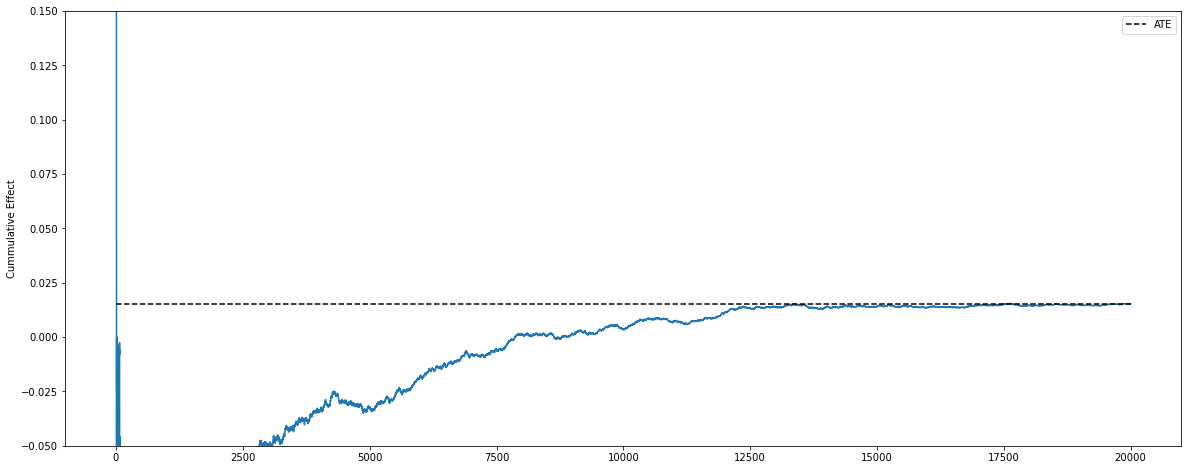

In [16]:
plt.figure(figsize=(20,8))
plt.plot(cumulative_effect_df_sure_thing_1st["size_test"]+cumulative_effect_df_sure_thing_1st["size_control"],
         cumulative_effect_df_sure_thing_1st["cumulative_effect"])

plt.hlines(ate, 0, len(cumulative_effect_df_sure_thing_1st), ls='dashed', color="black", label="ATE")
plt.legend()
plt.ylabel("Cummulative Effect")
plt.ylim([-0.05, 0.15])

In [17]:
cumulative_effect_df_lost_cause_1st = (
    test_ranked
    .sort_values("lost_cause_1st")
    .assign(
     agreement_test = lambda d: d["call"] * d["agreement"],
     agreement_control = lambda d: (1-d["call"]) * d["agreement"],
     size_test =  lambda d: d["call"],
     size_control =  lambda d: (1-d["call"]),
 )
 [["agreement_test", "agreement_control", "size_test", "size_control"]]
 .cumsum()
 .assign(cumulative_effect = lambda d: d["agreement_test"]/d["size_test"] - d["agreement_control"]/d["size_control"])

)

cumulative_effect_df_lost_cause_1st

,agreement_test,agreement_control,size_test,size_control,cumulative_effect
98621,0,0,0,1,NaN
3637,0,0,0,2,NaN
33631,0,0,1,2,0.000000
50003,0,0,1,3,0.000000
23290,0,0,1,4,0.000000
...,...,...,...,...,...
69081,2041,1849,10100,9896,0.015236
45111,2042,1849,10101,9896,0.015315
30040,2043,1849,10102,9896,0.015394
83602,2043,1850,10102,9897,0.015312


(-0.05, 0.15)

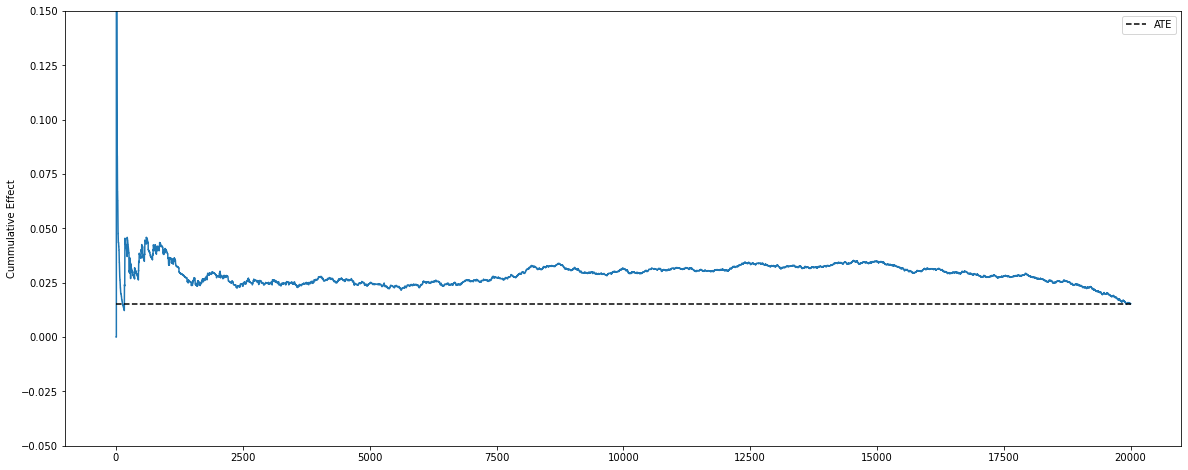

In [18]:
plt.figure(figsize=(20,8))
plt.plot(cumulative_effect_df_lost_cause_1st["size_test"]+cumulative_effect_df_lost_cause_1st["size_control"],
         cumulative_effect_df_lost_cause_1st["cumulative_effect"])

plt.hlines(ate, 0, len(cumulative_effect_df_lost_cause_1st), ls='dashed', color="black", label="ATE")
plt.legend()
plt.ylabel("Cummulative Effect")
plt.ylim([-0.05, 0.15])

# Ordenamento Baseado em Derivadas

In [19]:
test_ranked = test_pred.assign(
    lost_cause_1st = np.argsort(test_pred["prediction"]).argsort(),
    sure_thing_1st = np.argsort(-1*test_pred["prediction"]).argsort(),
    close_to_50_1st = np.argsort(np.abs(test_pred["prediction"]-0.5)).argsort(),
)

## Mais próximo de 50%

In [20]:
cumulative_effect_df_close_to_50_1st = (
    test_ranked
    .sort_values("close_to_50_1st")
    .assign(
     agreement_test = lambda d: d["call"] * d["agreement"],
     agreement_control = lambda d: (1-d["call"]) * d["agreement"],
     size_test =  lambda d: d["call"],
     size_control =  lambda d: (1-d["call"]),
 )
 [["agreement_test", "agreement_control", "size_test", "size_control"]]
 .cumsum()
 .assign(cumulative_effect = lambda d: d["agreement_test"]/d["size_test"] - d["agreement_control"]/d["size_control"])

)

cumulative_effect_df_close_to_50_1st

,agreement_test,agreement_control,size_test,size_control,cumulative_effect
65995,0,0,0,1,NaN
57952,0,0,0,2,NaN
46185,1,0,1,2,1.000000
69469,1,1,1,3,0.666667
53340,1,1,1,4,0.750000
...,...,...,...,...,...
23290,2043,1850,10101,9895,0.015294
50003,2043,1850,10101,9896,0.015313
33631,2043,1850,10102,9896,0.015293
3637,2043,1850,10102,9897,0.015312


(-0.05, 0.15)

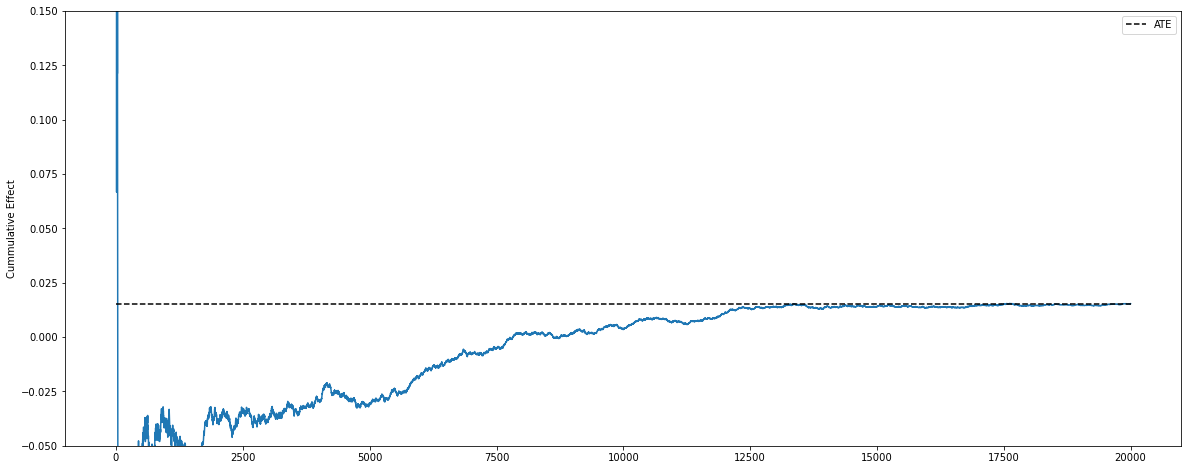

In [21]:
plt.figure(figsize=(20,8))
plt.plot(cumulative_effect_df_close_to_50_1st["size_test"]+cumulative_effect_df_close_to_50_1st["size_control"],
         cumulative_effect_df_close_to_50_1st["cumulative_effect"])

plt.hlines(ate, 0, len(cumulative_effect_df_close_to_50_1st), ls='dashed', color="black", label="ATE")
plt.legend()
plt.ylabel("Cummulative Effect")
plt.ylim([-0.05, 0.15])

## Modelo Causal Simples

In [22]:
from lightgbm import LGBMClassifier

causal_clf = LGBMClassifier()


X = [f"x{i}" for i in range(10)]

causal_clf.fit(train[X+["call"]], train["agreement"])

LGBMClassifier()

In [23]:
test_pred = test_pred.assign(
    deriv_prediction = causal_clf.predict_proba(test_pred[X].assign(call=1))[:, 1] - causal_clf.predict_proba(test_pred[X].assign(call=0))[:, 1]
)

test_pred.head()


,agreement,call,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,prediction,deriv_prediction
43660,0,0,-1.159491,-0.090660,2.430949,-1.127080,0.761413,-2.398350,-1.393830,0.008505,-1.804984,-0.617416,0.055956,-0.033081
87278,0,1,0.161243,-0.496317,0.863277,0.320810,1.949677,1.021588,-1.482750,0.582966,-0.037880,-0.214991,0.293817,0.088442
14317,0,0,1.393299,2.086833,0.139414,0.826503,0.097820,1.507955,-1.105425,0.341311,-0.145129,1.254981,0.116230,-0.018872
81932,0,1,-1.666458,-2.761416,0.583532,0.160105,1.717938,0.305316,1.956600,-0.137366,0.707691,1.274815,0.169452,0.347485
95321,0,0,1.697644,1.080617,0.649876,1.316316,0.319485,-0.298049,0.243747,-0.444826,0.921988,0.535202,0.087090,-0.036346


In [24]:
test_ranked = test_pred.assign(
    lost_cause_1st = np.argsort(test_pred["prediction"]).argsort(),
    sure_thing_1st = np.argsort(-1*test_pred["prediction"]).argsort(),
    close_to_50_1st = np.argsort(np.abs(test_pred["prediction"]-0.5)).argsort(),
    high_deriv_1st = np.argsort(-1*test_pred["deriv_prediction"]).argsort(),
)

test_ranked.sort_values(["high_deriv_1st"])

,agreement,call,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,prediction,deriv_prediction,lost_cause_1st,sure_thing_1st,close_to_50_1st,high_deriv_1st
24181,1,1,-1.336192,-2.521239,-0.513799,0.150143,1.298106,1.792662,0.114836,0.857446,-1.959142,-0.063700,0.400271,0.782869,17638,2361,1859,0
96619,0,0,0.426374,-2.266634,-1.239955,2.685777,1.332310,1.866959,0.750656,0.080033,0.021534,-1.568641,0.673524,0.733359,19787,212,3465,1
85424,1,1,-1.097317,-2.381872,-0.649158,0.072231,-0.209131,0.646079,-0.033616,-1.341663,-2.376823,-1.339155,0.374447,0.732442,17256,2743,2356,2
38282,0,0,-1.159534,-2.302738,0.106635,0.450348,0.961823,1.397829,-0.188850,-0.946370,-1.405352,-1.166850,0.298610,0.720374,15658,4341,4186,3
81971,1,1,-0.633168,-2.422002,-0.149869,0.999430,0.990098,0.849382,-0.240825,0.759178,-1.017341,-1.840667,0.572426,0.719771,19338,661,1309,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19365,1,0,0.260678,1.634242,0.018614,-0.851287,0.405899,-2.422536,-0.676943,-1.478162,0.434040,1.631969,0.362696,-0.699826,17055,2944,2606,19995
11287,0,1,2.692935,1.657792,-0.266750,-1.225804,0.802654,-2.105247,0.178585,-0.359876,-0.646146,2.243397,0.551654,-0.702480,19193,806,903,19996
16371,1,0,1.961369,1.034285,0.307684,0.228382,1.081897,-2.802280,-1.179708,0.635849,0.149375,0.072811,0.459828,-0.708978,18418,1581,696,19997
2284,0,1,0.888609,0.899017,-0.332905,0.497530,1.310246,-2.113098,-0.342935,0.260192,0.159337,1.460655,0.458079,-0.715905,18400,1599,726,19998


In [25]:
cumulative_effect_df_high_deriv_1st = (
    test_ranked
    .sort_values("high_deriv_1st")
    .assign(
     agreement_test = lambda d: d["call"] * d["agreement"],
     agreement_control = lambda d: (1-d["call"]) * d["agreement"],
     size_test =  lambda d: d["call"],
     size_control =  lambda d: (1-d["call"]),
 )
 [["agreement_test", "agreement_control", "size_test", "size_control"]]
 .cumsum()
 .assign(cumulative_effect = lambda d: d["agreement_test"]/d["size_test"] - d["agreement_control"]/d["size_control"])

)

cumulative_effect_df_high_deriv_1st

,agreement_test,agreement_control,size_test,size_control,cumulative_effect
24181,1,0,1,0,NaN
96619,1,0,1,1,1.000000
85424,2,0,2,1,1.000000
38282,2,0,2,2,1.000000
81971,3,0,3,2,1.000000
...,...,...,...,...,...
19365,2043,1849,10099,9897,0.015473
11287,2043,1849,10100,9897,0.015453
16371,2043,1850,10100,9898,0.015371
2284,2043,1850,10101,9898,0.015351


(-0.05, 0.8)

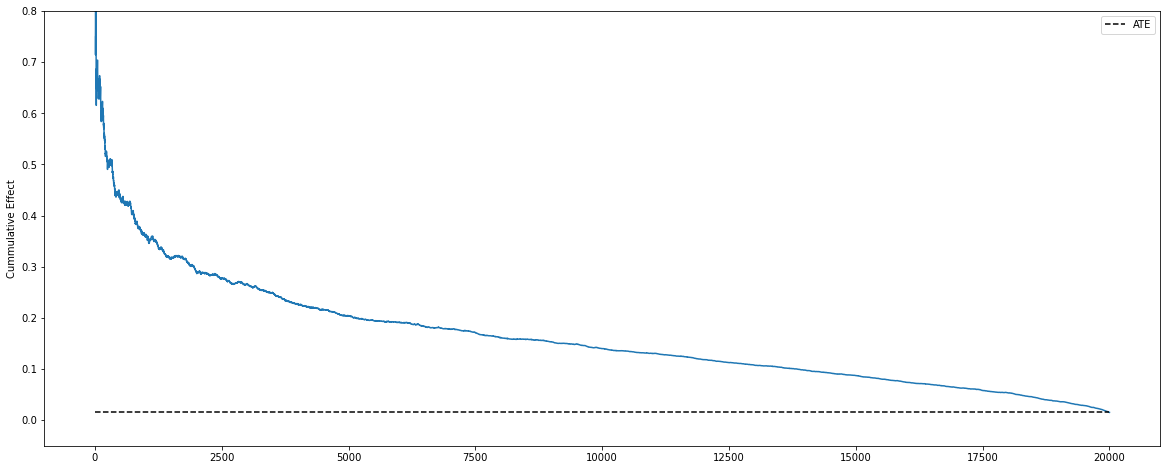

In [26]:
plt.figure(figsize=(20,8))
plt.plot(cumulative_effect_df_high_deriv_1st["size_test"]+cumulative_effect_df_high_deriv_1st["size_control"],
         cumulative_effect_df_high_deriv_1st["cumulative_effect"])

plt.hlines(ate, 0, len(cumulative_effect_df_high_deriv_1st), ls='dashed', color="black", label="ATE")
plt.legend()
plt.ylabel("Cummulative Effect")
plt.ylim([-0.05, 0.8])